In [1]:
%load_ext pycodestyle_magic

In [2]:
%pycodestyle_on

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing, decomposition
from sklearn.decomposition import KernelPCA
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
from functions2 import *
# You can find all the class and functions in the clustering.py
from clustering import prepData, clustering, plotClustering

Random State is 42 by default, you can change it in the functions parameters.
Functions still in build : ACP, Hierarchical Clustering, allClustering. Do not use it


In [4]:
# Let's first fix the random seed to 42
# (as it's the default value in my clustering library)
np.random.seed(42)

In [5]:
data_group = pd.read_csv('files_cleaned/data_group.csv')
try:
    data_group = data_group.drop(columns=['Unnamed: 0'])
except KeyError:
    pass
data_group = data_group.set_index('customer_unique_id')

# We get data_categ_country to have the categ
# And country features for after clustering
data_categ_country = pd.read_csv('files_cleaned/data_categ_country.csv')
try:
    data_categ_country = data_categ_country.drop(columns=['Unnamed: 0'])
except KeyError:
    pass
data_categ_country = data_categ_country.set_index('customer_unique_id')

In [6]:
data = data_group[['sum_of_price',
                   'nbr_orders_current_year',
                   'nbr_day_since_last_order']]

# ACP

In [7]:
n_comp = len(data_group.columns)

data_pca = data_group.copy()

data_pca = data_pca.fillna(data_pca.mean())

# We only take the values
X = data_pca.values

names = data_pca.index
features = data_pca.columns

# Preprocessing
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Principal components calculation
pca = decomposition.PCA(n_components=n_comp)
pca = pca.fit(X_scaled)

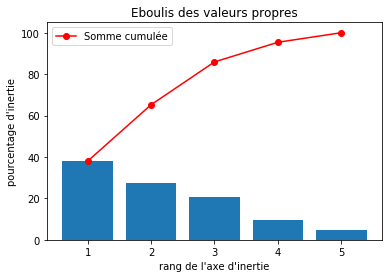

In [8]:
display_scree_plot(pca)

The PCA needs all of the components to explain 100 % of data ; <br/>
We won't use it for next steps

# Kernel PCA

Preprocessing

In [9]:
data_pca = data_group.copy()
data_pca = data_pca.fillna(data_pca.mean())

# We only take the first 10 000 rows ; My machine is not powerfull
# Enough to use Kernel PCA on all the Dataset
data_pca = data_pca.sample(n=10000)

Kernel PCA set up

In [10]:
n_comp = len(data_group.columns)
kernel_ = 'linear'

transformer = KernelPCA(n_components=n_comp,
                        kernel=kernel_, copy_X=False, n_jobs=-1)
X_transformed = transformer.fit_transform(data_pca)

Variance explained by component for ploting

In [11]:
explained_variance = np.var(X_transformed, axis=0)
explained_variance_ratio = explained_variance / np.sum(explained_variance)

Scree plot

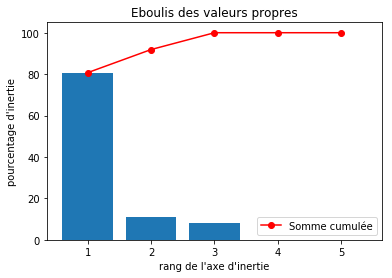

In [12]:
scree = explained_variance_ratio*100
plt.bar(np.arange(len(scree))+1, scree)
plt.plot(np.arange(len(scree))+1, scree.cumsum(),
         c="red", marker='o', label="Somme cumulée")
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.legend(loc="best")
plt.show(block=False)

We need 3 components on the 10 we had to explain 100% of the information ; Kernel PCA is effective ! <br/>
Unfortunately, as said before, my machine isn't powerfull enough to make PCA on all dataset. We won't be able to use it for next steps.

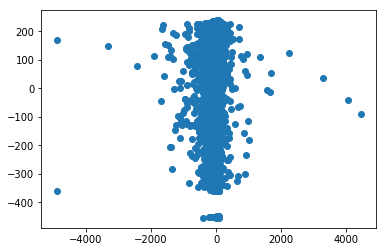

In [13]:
# We'll still plot the components to see if clusters are visible
plt.scatter(X_transformed[:, 1], X_transformed[:, 2])
plt.show()

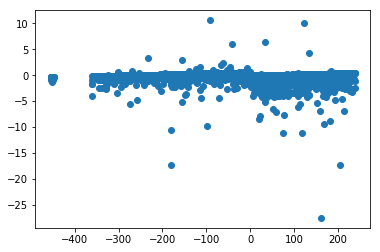

In [14]:
plt.scatter(X_transformed[:, 2], X_transformed[:, 3])
plt.show()

There is no obvious clusters here, but the at least the Kernel PCA would have reduce the time of computation (and maybe enable me to try Hierarchical Clustering or better DB_SCAN).

# Clustering (With my set of class and functions)

## Kmeans

In [15]:
data = data_group.copy()

Preprocessing

In [16]:
X_scaled = prepData.centrageReduction(data)

Elbow curve (note that the elbow method is not implemented in my functions yet)

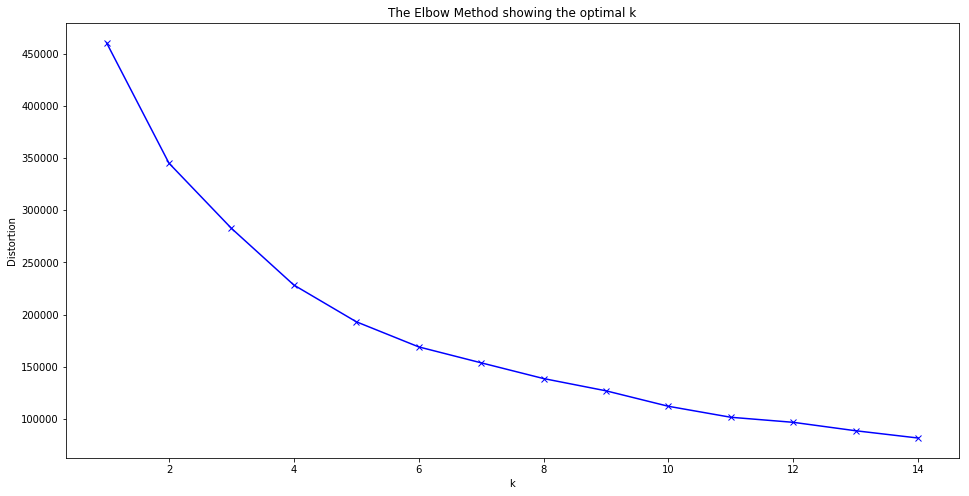

In [17]:
from sklearn.cluster import KMeans
distortions = []
K = range(1, 15)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X_scaled)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(16, 8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

The curve seems to break at k=5, we will verify that by computing the silhouette coefficient:

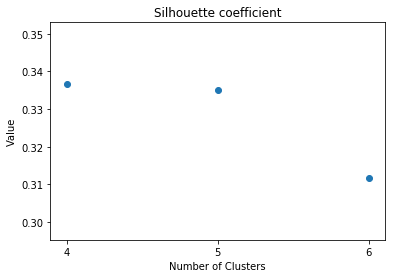

In [18]:
silouhette_coef = clustering.silhouette(data, X_scaled, 4, 6)

We can see here that the best silhouette score is for 4 clusters. <br/>
Actually, we'll take 5 clusters as this allows us to get a category of customer that we would not have with 4 clusters. <br/>

Clustering with kmeans

In [19]:
data_clust = clustering.makeClustering(data, X_scaled, 5)

Group by cluster for better vizualisation of each cluster's meaning

In [20]:
data_grouped = clustering.grouping(data_clust)

Plots 

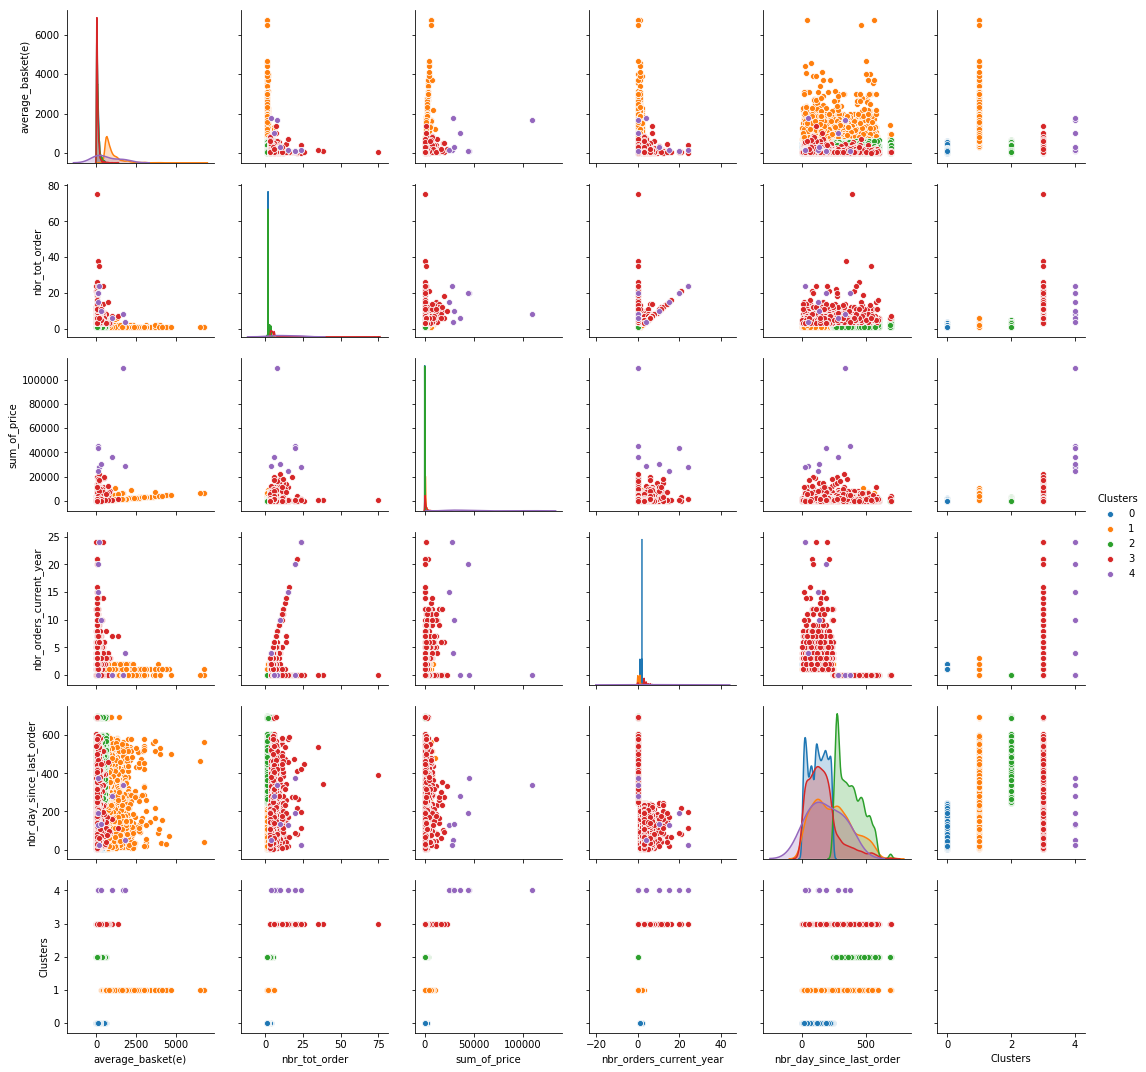

In [21]:
plotClustering.plotPairplot(data_clust)

As we can see here, clusters are not really separated. Or at least we cannot, by eye, really differenciate them <br/>
Let's see with a boxplot :

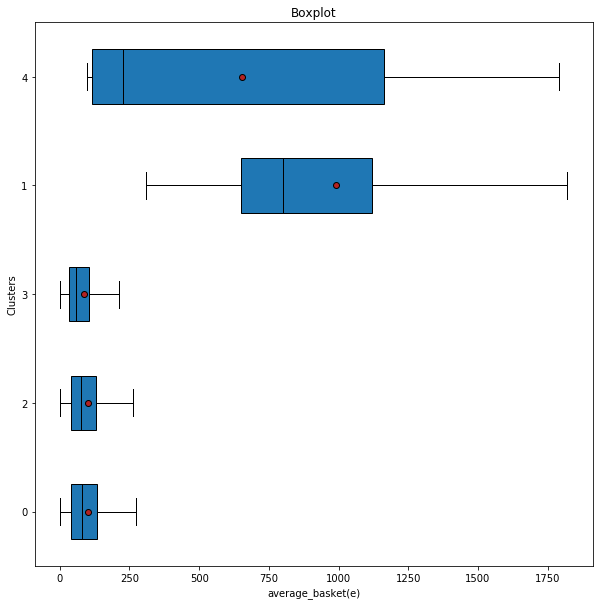

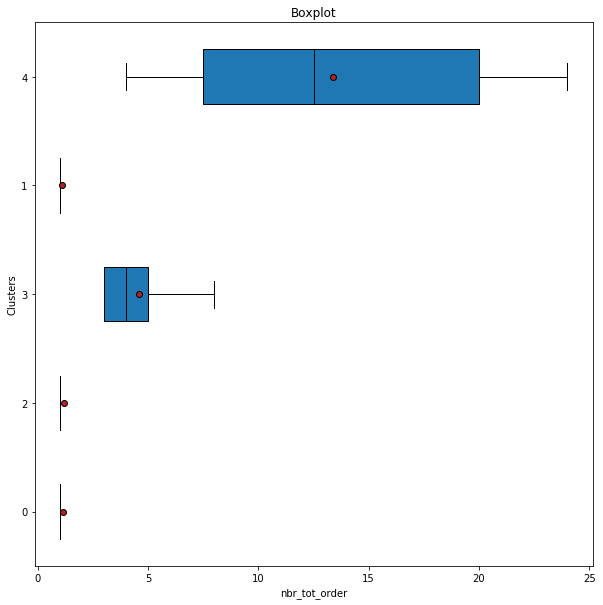

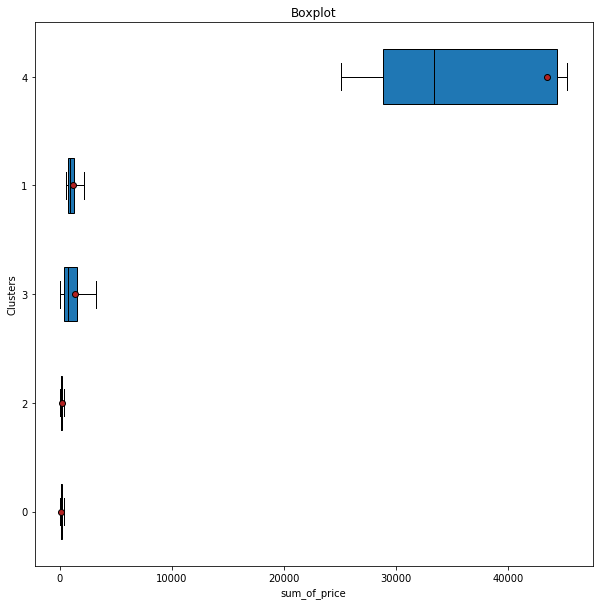

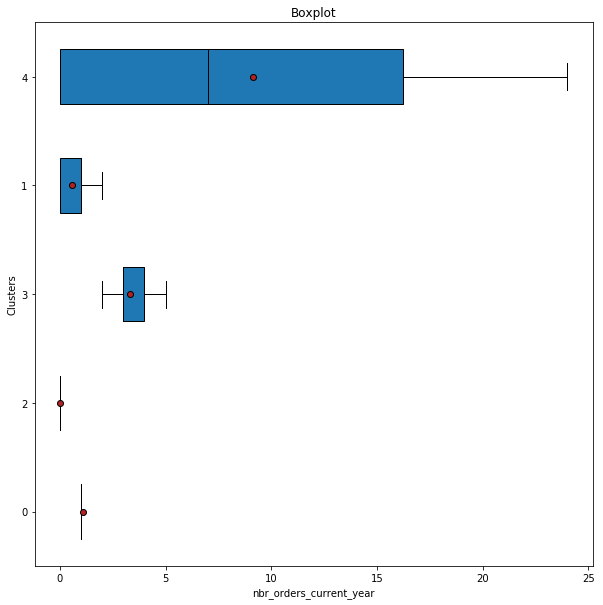

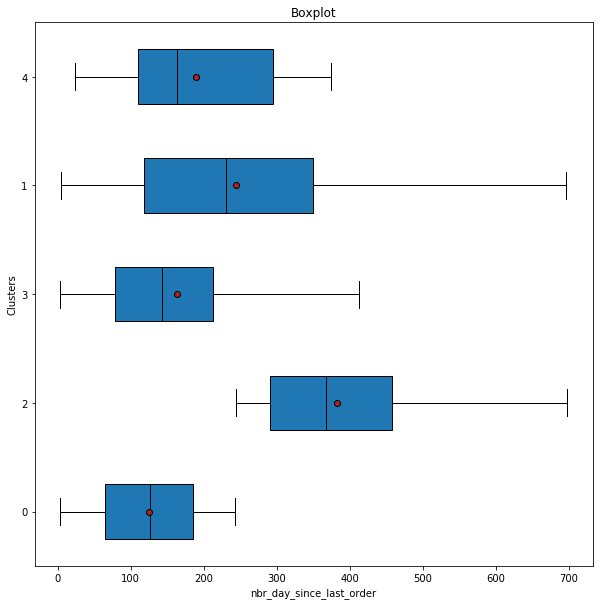

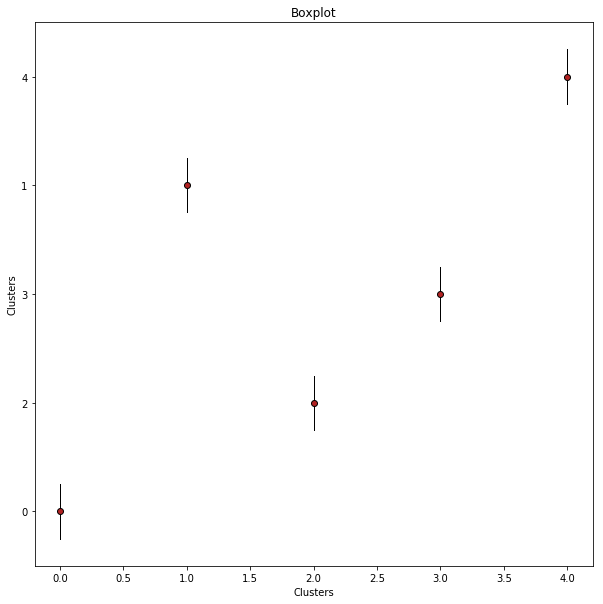

In [22]:
plotClustering.plotBoxplot(data_clust)

Boxplot is a bit more accurate in this case and let us see that there actually is a difference between clusters. <br/>
But, the difference is not on only one variable, more like 2 or 3. That is why the pairplot was not usefull. <br/>
Not let's see with the radar plot : 

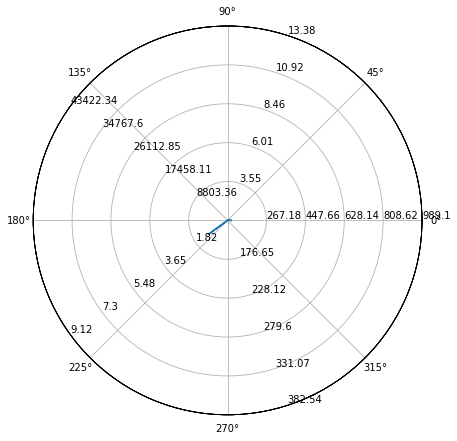

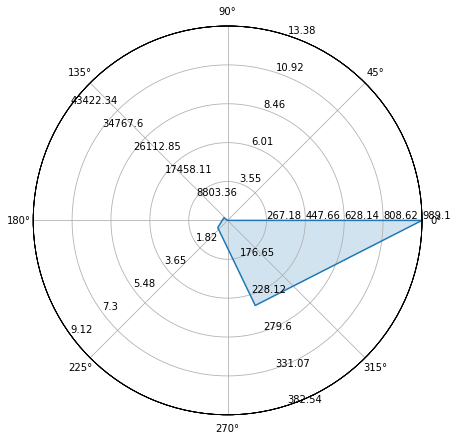

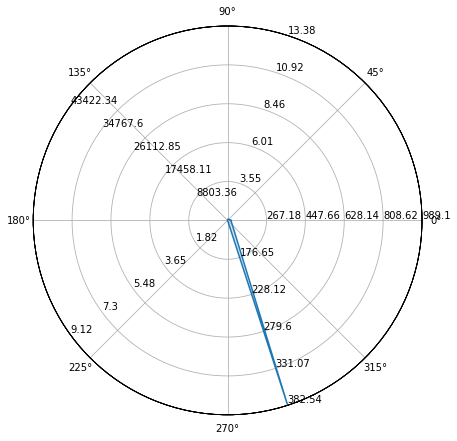

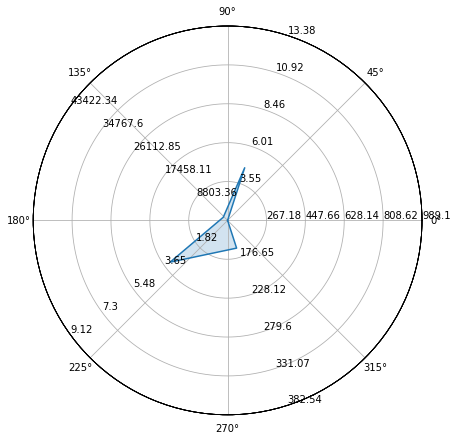

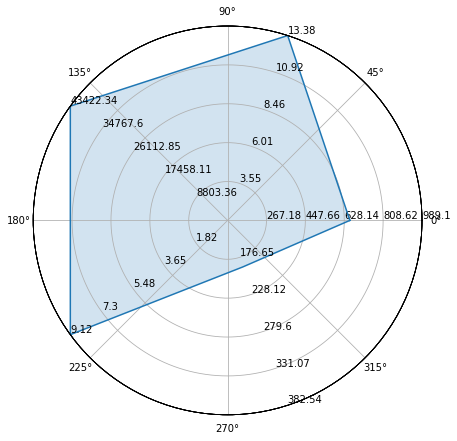

In [23]:
plotClustering.plotRadarPlot(data_grouped)

As those data tend to take either a big value or a really small one, the radar for3 of the 5 clusters does not show a lot of info. <br/>
Or at least not more that just a print of the dataframe of grouped clusters :

In [24]:
data_grouped

,average_basket(e),nbr_tot_order,sum_of_price,nbr_orders_current_year,nbr_day_since_last_order
Clusters,,,,,
0,103.152292,1.121523,148.616727,1.109231,125.178121
1,989.097380,1.092434,1151.503382,0.573415,243.584458
2,102.112933,1.186561,160.381582,0.000000,382.544080
3,86.698304,4.588751,1339.152882,3.334716,163.765791
4,654.279833,13.375000,43422.343750,9.125000,190.000000


We are now able to name our cluster (normally you, reader, should have the clusters in the same order as I had when I wrote those lines, if not you can easily figure out which cluster I'm taking about) :

<li><ul> Cluster 1 : 1 time active customer with little amount</ul>
    <ul> Cluster 2 : 1 time to reach customer with big amount</ul>
    <ul> Cluster 3 : 1 time unactive customer with little amount</ul>
    <ul> Cluster 4 : Regular customer with little amount</ul>
    <ul> Cluster 5 : Regular customer with big amount</ul></li>

Let's now see how much people we have in each cluster : (This will be implemented in the set of functions later on, had no time yet to do it)

In [25]:
count = data_clust.groupby('Clusters').count()
count

,average_basket(e),nbr_tot_order,sum_of_price,nbr_orders_current_year,nbr_day_since_last_order
Clusters,,,,,
0,47917,47917,47917,47917,47917
1,2445,2445,2445,2445,2445
2,39542,39542,39542,39542,39542
3,2169,2169,2169,2169,2169
4,8,8,8,8,8


The count shows us some important things : <br/>
<li><ul> There is more 1 time active customers than 1 time inactive customers. Which shows that the website is in good health</ul>
    <ul> There is 2 445 customers that are between active and unactive. A good thing would be to reach those customers</ul>
    <ul> There is 8 really big cutomers that the website needs to keep</ul></li>

## Affectation d'un nom à chaque cluster

In [26]:
data_final = data_clust.copy()

# We use np.where to affiliate each clusters to two types :
# Regular customer and 1 time customer
data_final['type1'] = (np.where((data_final['Clusters'] == 3) |
                                (data_final['Clusters'] == 4),
                                'regular', '1 time'))

data_final['type2'] = (np.where(data_final['Clusters'] == 2,
                                'unactive', 'active'))
data_final[data_final['Clusters'] == 1] = 'To reach'

# Big or Little amount
data_final['type3'] = np.where((data_final['Clusters'] == 1) |
                               (data_final['Clusters'] == 4),
                               'big amount', 'little amount')

# Then, we can add the country and the cateogory of product.
# Usefull information for Marketing
data_final = pd.merge(data_final, data_categ_country,
                      left_index=True, right_index=True,
                      how='left')

Let's print the DataFrame : 

In [27]:
data_final.head()

,average_basket(e),nbr_tot_order,sum_of_price,nbr_orders_current_year,nbr_day_since_last_order,Clusters,type1,type2,type3,customer_state,product_category_name
customer_unique_id,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,129.9,1,141.9,1,114,0,1 time,active,little amount,SP,cama_mesa_banho
0000b849f77a49e4a4ce2b2a4ca5be3f,18.9,1,27.19,1,117,0,1 time,active,little amount,SP,beleza_saude
0000f46a3911fa3c0805444483337064,69,1,86.22,0,540,2,1 time,unactive,little amount,SC,papelaria
0000f6ccb0745a6a4b88665a16c9f078,25.99,1,43.62,0,324,2,1 time,unactive,little amount,PA,telefonia
0004aac84e0df4da2b147fca70cf8255,180,1,196.89,0,291,2,1 time,unactive,little amount,SP,telefonia


## Db_scan

To begin with, I did not spend a lot of time on DB_SCAN ; There is two reasons for that : <br/>
<ol><li> The kmeans clustering shows the different clusters that I think are usefull for Marketing </li>
    <li> It was really hard to use DB_SCAN with the machine that I have on all the dataset. That was only possible by optimizing the code and my machine (just jupyter opened, all useless background programs closed, etc...)</li></ol> <br/>
Optimizing the parameters by a loop is not possible here (as it was made with kmeans) ; I launched some test with different epsilon and min_sample. But the algo could be optimized more. <br/>
Anyway, here is the only shot I had to launch DB_SCAN :

In [28]:
data = data_group.copy()

Preprocessing

In [29]:
X_scaled = prepData.centrageReduction(data)

Clustering with DB_SCAN

In [30]:
data_clust = clustering.makeClustering(data, X_scaled, 500,
                                       algo='db_scan', epsilon=0.3)

Group the data for better visualisations after

In [31]:
data_grouped = clustering.grouping(data_clust)

Plots 

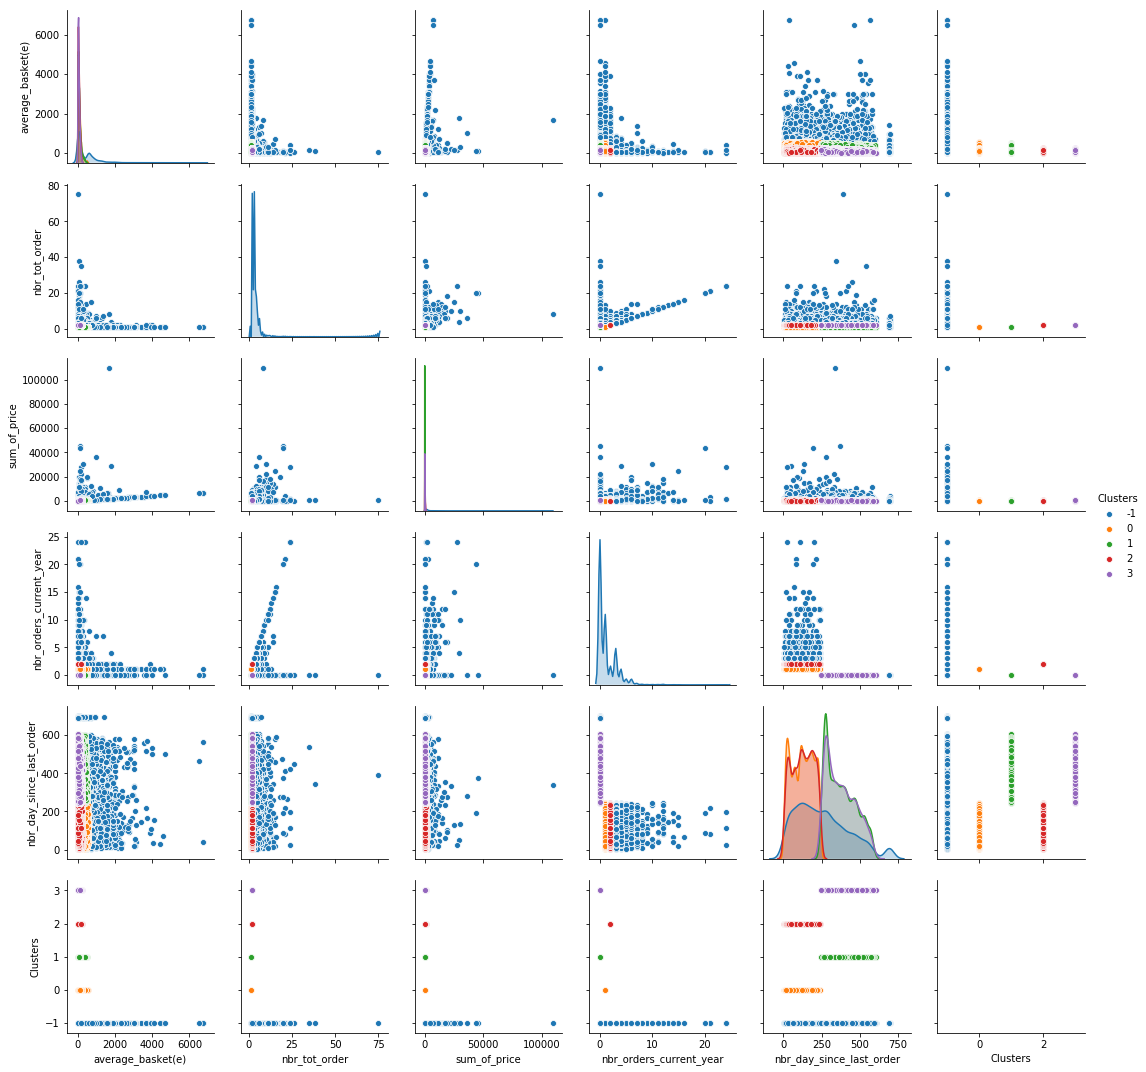

In [32]:
plotClustering.plotPairplot(data_clust)

In [33]:
data_grouped

,average_basket(e),nbr_tot_order,sum_of_price,nbr_orders_current_year,nbr_day_since_last_order
Clusters,,,,,
-1,414.810220,2.614346,1026.227937,1.300813,258.869656
0,104.284985,1.000000,124.371310,1.000000,124.930387
1,101.473454,1.000000,120.311407,0.000000,380.050976
2,74.950369,2.000000,287.509181,2.000000,126.908701
3,69.830362,2.000000,255.337292,0.000000,379.470015


In [34]:
count = data_clust.groupby('Clusters').count()
count

,average_basket(e),nbr_tot_order,sum_of_price,nbr_orders_current_year,nbr_day_since_last_order
Clusters,,,,,
-1,7626,7626,7626,7626,7626
0,42147,42147,42147,42147,42147
1,33310,33310,33310,33310,33310
2,4896,4896,4896,4896,4896
3,4102,4102,4102,4102,4102


## Hierarchical Clustering

As for DB_SCAN, hierarchical clustering was not possible on full data on my machine

We will take a sample of our data (in this case 500, could go for a higher sample, but as I won't use that algo, let's keep it simple to compute)

In [35]:
data_dendro = data_group.copy()
data_dendro = data_dendro.sample(n=500)

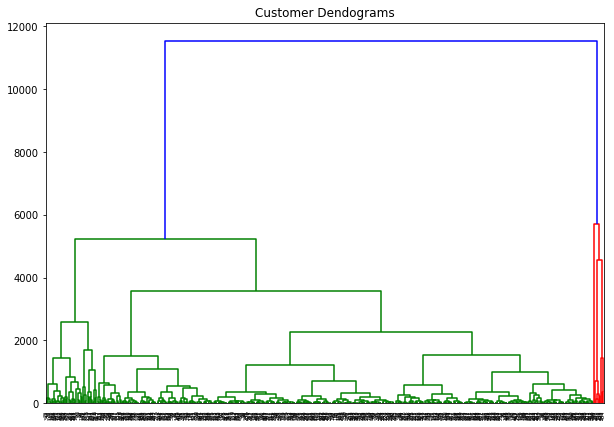

In [36]:
plt.figure(figsize=(10, 7))
plt.title("Customer Dendograms")
dend = shc.dendrogram(shc.linkage(data_dendro, method='ward'))

In [37]:
cluster = (AgglomerativeClustering(n_clusters=5,
                                   affinity='euclidean',
                                   linkage='ward'))
cluster.fit_predict(data_dendro)

array([0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 4, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 4, 0, 1, 0, 3, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

As we fit the model on only 500 data (even if the sample is chosen randomly), the result is not usable. We won't plot or analyse the results.